# The Krotov and Hopfield model

Here, we want to study the combined model proposed by Krotov and Hopfield, featuring a first layer that is trained using Local Learning Rules and a second layer that we train using back propagation

In [2]:
import os

import torch
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch.optim import Adam

from pathlib import Path
from context import LocalLearning
from tqdm.notebook import tqdm
import numpy as np
from matplotlib import pyplot as plt

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Loading a model that has the desired spectral properties

In [4]:
llmodels_path = Path("../data/models/L3UnitCIFAR10_ensemble")
file_names = os.listdir(llmodels_path)
file_names = [fn for fn in file_names if os.path.isfile(llmodels_path / Path(fn))]

In [5]:
# array that encodes whether model satisfies the stringer spectra or not
scales_stringer_spectra = np.array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

# array containing all the filenames that scale stringer
file_names_scales_stringer = np.array(file_names)[scales_stringer_spectra]

In [6]:
# initilise the model

model_file = Path(file_names_scales_stringer[0])
ll_trained_state = torch.load(llmodels_path / model_file)
khmodel = LocalLearning.KHModel(ll_trained_state)
khmodel.to(device)

KHModel(
  (local_learning): FKHL3(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (relu_h): ReLU()
  (dense): Linear(in_features=2000, out_features=10, bias=True)
  (softMax): Softmax(dim=-1)
)

# Training the model

In [7]:
# Hyper parameters:
BATCH_SIZE = 1000
NUMBER_OF_EPOCHS = 1000
LEARNING_RATE = 1e-4

In [7]:
khmodel.train()

cifar10Train= LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=True,
    transform=ToTensor(),
    p=khmodel.pSet["p"],
)

TrainLoader = LocalLearning.DeviceDataLoader(
    cifar10Train,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

cifar10Test= LocalLearning.LpUnitCIFAR10(
    root="../data/CIFAR10",
    train=False,
    transform=ToTensor(),
    p=khmodel.pSet["p"],
)

TestLoader = LocalLearning.DeviceDataLoader(
    cifar10Test,
    device=device,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=True,
)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
khmodel.pSet

{'in_size': 3072,
 'hidden_size': 2000,
 'n': 4.5,
 'p': 3.0,
 'tau_l': 49999.999999999956,
 'k': 2,
 'Delta': 0.4,
 'R': 1.0}

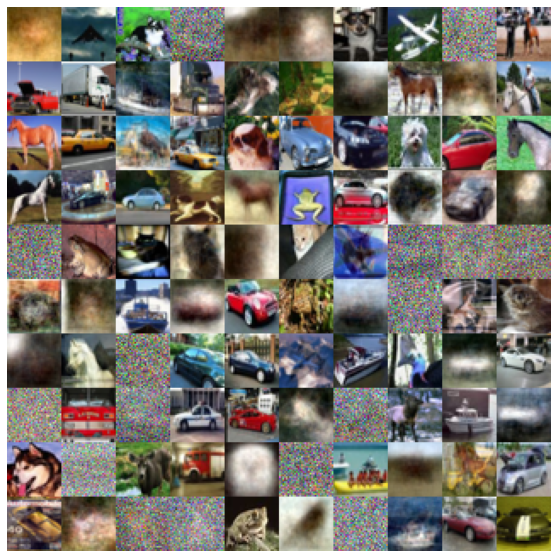

In [9]:
def minmaxnorm(a):
    a_ = a - a.min()
    return a_ / a_.max()

def draw_weights(synapses, n_hiddenx, n_hiddeny, n_pixelx=32, n_pixely=32, n_chan=3):
    cnt = 0
    synapses = synapses[np.random.choice(synapses.shape[0], n_hiddenx*n_hiddeny, replace=False)]
    HM = np.zeros((n_pixely*n_hiddeny, n_pixelx*n_hiddenx, n_chan))
    for y in range(n_hiddeny):
        for x in range(n_hiddenx):
            HM[y*n_pixely:(y+1)*n_pixely, x*n_pixelx:(x+1)*n_pixelx, :] = minmaxnorm(synapses[cnt].reshape(n_pixely, n_pixelx, n_chan))
            cnt += 1

    nc = np.max(np.absolute(HM))
    im = plt.imshow(HM, vmin=-nc, vmax=nc)
    plt.axis('off')
    
fig = plt.figure(figsize = (12.9, 10))
draw_weights(khmodel.local_learning.W.T.detach().cpu().numpy(), 10, 10)

In [10]:
list(khmodel.parameters())

[Parameter containing:
 tensor([[0.0499, 0.1098, 0.0185,  ..., 0.0677, 0.0450, 0.1407],
         [0.0547, 0.0906, 0.0338,  ..., 0.0754, 0.0464, 0.1420],
         [0.0321, 0.0067, 0.0064,  ..., 0.0760, 0.0424, 0.1420],
         ...,
         [0.0717, 0.0388, 0.0492,  ..., 0.0677, 0.0477, 0.0295],
         [0.0725, 0.0159, 0.0690,  ..., 0.0655, 0.0447, 0.0295],
         [0.0734, 0.1157, 0.0249,  ..., 0.0655, 0.0391, 0.0339]],
        device='cuda:0'),
 Parameter containing:
 tensor([[-0.0121, -0.0086,  0.0139,  ...,  0.0022,  0.0022, -0.0189],
         [ 0.0047, -0.0145,  0.0001,  ..., -0.0173,  0.0099, -0.0219],
         [ 0.0218,  0.0213,  0.0038,  ..., -0.0091, -0.0018,  0.0037],
         ...,
         [ 0.0170, -0.0104, -0.0046,  ...,  0.0222, -0.0063,  0.0026],
         [-0.0114,  0.0019, -0.0004,  ..., -0.0213,  0.0069, -0.0029],
         [-0.0094,  0.0223,  0.0128,  ..., -0.0219, -0.0099, -0.0182]],
        device='cuda:0', requires_grad=True)]

In [11]:
# define loss function that we want to use
ce_loss = torch.nn.CrossEntropyLoss()
AdamOpt = Adam(khmodel.parameters(), lr=LEARNING_RATE)

In [12]:
def train(
    data: DataLoader,
    test: DataLoader,
    model: LocalLearning.KHModel, 
    loss_fn, 
    optimizer, 
    no_epochs=NUMBER_OF_EPOCHS,
    checkpt_period=1,
    loss_history=[],
    test_history=[],
    ):
    with tqdm(range(1, no_epochs + 1), unit="epoch") as tepoch:
        tepoch.set_description(f"Training time [epochs]")
        
        for epoch in tepoch:
            
            cumm_loss = 0.0
            model.train()
            for batch_no, (features, labels) in enumerate(data):
                preds = model(features)
                loss = loss_fn(preds, labels)
                cumm_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        
            loss_history.append(cumm_loss)
            
            freq_correct = 0
            model.eval()
            for batch_no, (features, labels) in enumerate(test):
                preds = torch.argmax(model(features), dim=-1)
                freq_correct += (torch.abs(preds - labels) == 0).sum()
            
            test_history.append(freq_correct / (len(test)*test.batch_size))
    

In [13]:
loss_history = []
accuracy_history = []
train(TrainLoader, TestLoader, khmodel, ce_loss, AdamOpt, loss_history=loss_history, test_history=accuracy_history)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Text(0, 0.5, 'Accuracy(t)')

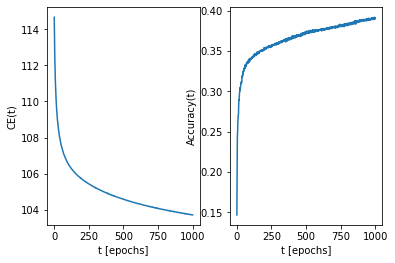

In [14]:
fig, axs = plt.subplots(1, 2)
loss_history_cpu = np.array([a.cpu().detach().numpy() for a in loss_history])
accuracy_history_cpu = np.array([a.cpu().detach().numpy() for a in accuracy_history])
axs[0].plot(loss_history_cpu)
axs[0].set_xlabel(r"t [epochs]")
axs[0].set_ylabel(r"CE(t)")
axs[1].plot(accuracy_history_cpu)
axs[1].set_xlabel(r"t [epochs]")
axs[1].set_ylabel(r"Accuracy(t)")

In [16]:
# save the model
torch.save(
    {
        "fkhl3-path": str(llmodels_path / model_file),
        "fkhl3-state": ll_trained_state,
        "model_state_dict": khmodel.state_dict(),
        "loss_history": loss_history,
        "accuracy_history": accuracy_history,
    },
    llmodels_path.parent / Path("KHModelCIFAR10_ensemble") / Path("KHModel_" + str(model_file)),
)

In [1]:
cifar10Train.data

NameError: name 'cifar10Train' is not defined